/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔥 [Start] Hyper-Realistic Pipeline with Deep Visualization

🔶 [STAGE A] 베이스 이미지 생성...
    [AI] BiRefNet (누끼) 실행...


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


    [AI] Flux (배경 생성) 실행...


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
  0%|          | 0/25 [00:00<?, ?it/s]/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 25/25 [01:02<00:00,  2.52s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


    [AI] Flux (리터칭) 실행 - 사실감 부여 중...


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
100%|██████████| 18/18 [00:45<00:00,  2.54s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.



🔶 [STAGE B] 텍스트 자산 생성...
    [AI] SDXL (3D 텍스트) 실행...


100%|██████████| 30/30 [00:17<00:00,  1.76it/s]


    [AI] BiRefNet (누끼) 실행...

🔶 [STAGE C] 최종 합성...


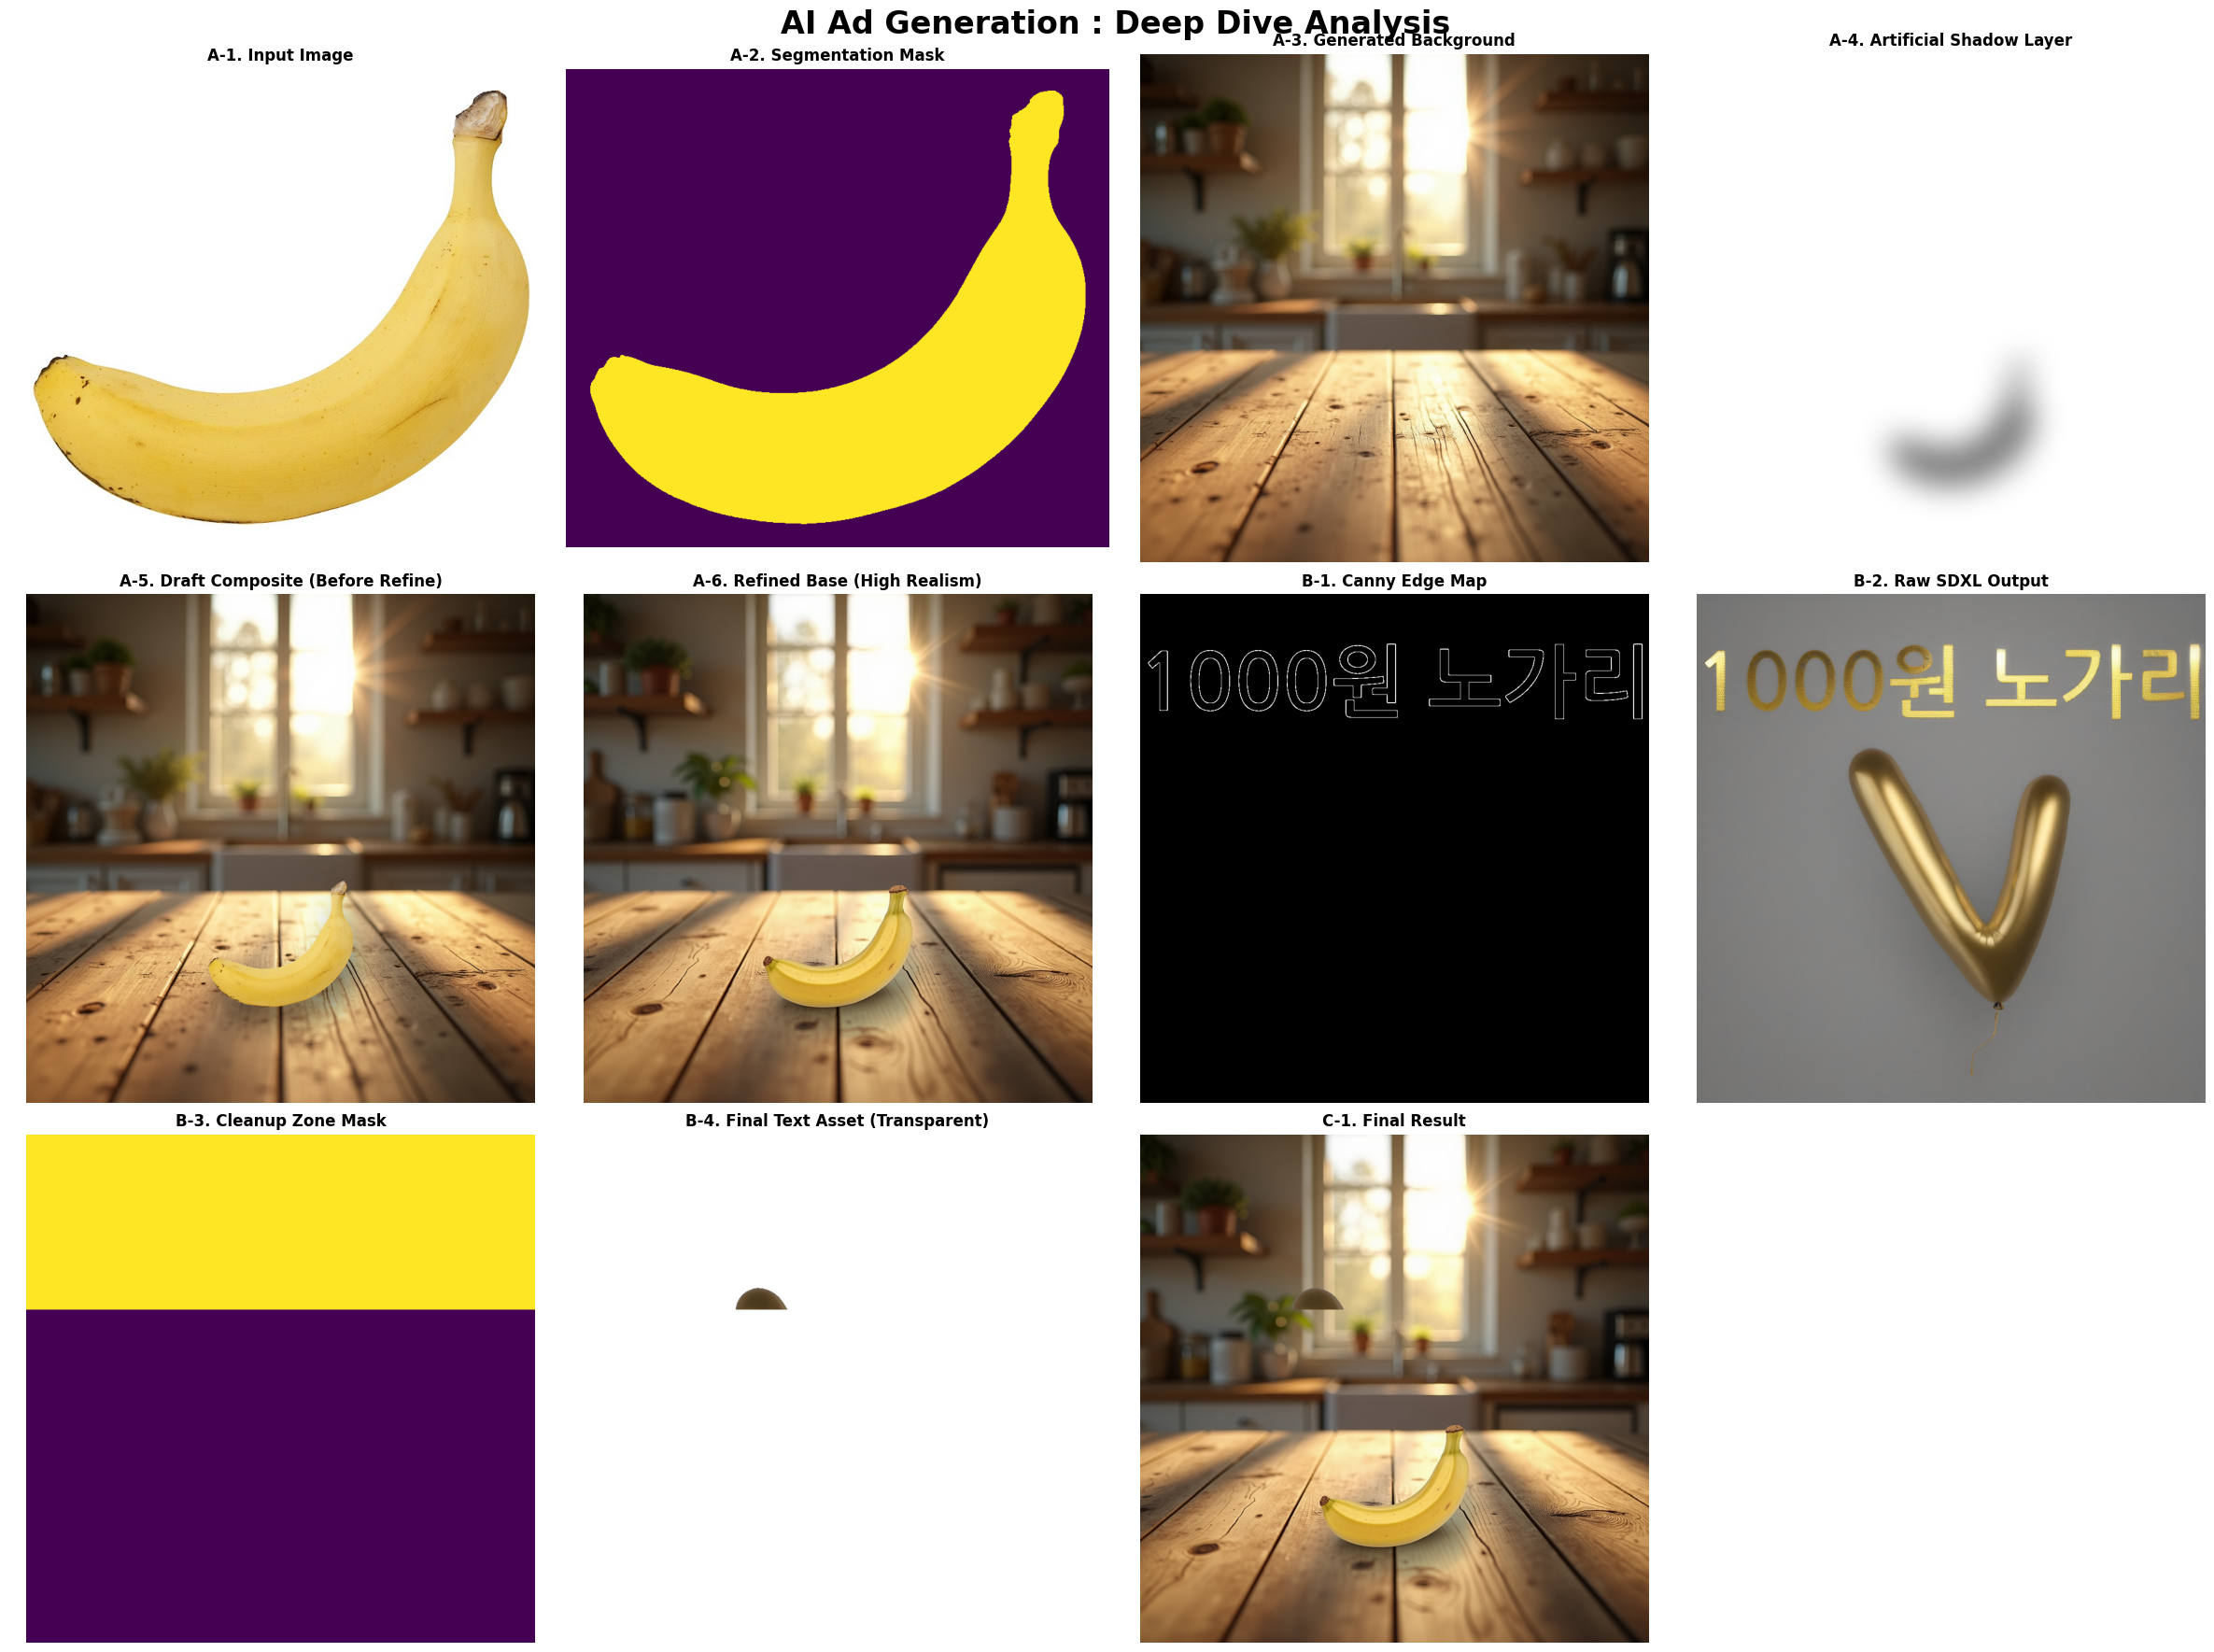


✨ 최종 결과 완료: final_result_v4.png


In [ ]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps, ImageChops
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
from diffusers import (
    FluxPipeline,
    FluxImg2ImgPipeline, 
    FluxTransformer2DModel,
    StableDiffusionXLControlNetPipeline, 
    ControlNetModel, 
    AutoencoderKL
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 설정
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 

MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def pil_canny_edge(image):
    """
    [시각화 포인트] Canny Edge는 AI가 텍스트 형태를 인식하는 '설계도'입니다.
    검은 배경에 흰 선으로 표현됩니다.
    """
    gray = image.convert("L")
    edges = gray.filter(ImageFilter.FIND_EDGES)
    edges = edges.point(lambda x: 255 if x > 30 else 0)
    return edges.convert("RGB")

def visualize_detailed_report(images_dict):
    """
    12단계 상세 분석 리포트를 생성합니다.
    """
    n = len(images_dict)
    cols = 4  # 한 줄에 4개씩 배치
    rows = (n + cols - 1) // cols
    
    plt.figure(figsize=(24, 6 * rows))
    plt.suptitle("AI Ad Generation : Deep Dive Analysis", fontsize=24, fontweight='bold', y=0.98)
    
    for i, (key, img) in enumerate(images_dict.items()):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(key, fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # 디버깅용 개별 파일 저장
        safe_name = f"debug_step_{i+1}.png"
        img.save(safe_name)

    plt.tight_layout()
    plt.show()

# --- AI Core Functions ---
def _run_birefnet_seg(image):
    print("    [AI] BiRefNet (누끼) 실행...")
    flush()
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        MODEL_IDS["SEG"], trust_remote_code=True
    ).to(DEVICE).eval()
    
    W, H = image.size
    img_resized = image.resize((1024, 1024), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 128 else 0)
    
    result = image.copy()
    result.putalpha(mask)
    del birefnet, input_tensor
    flush()
    return result, mask

def _run_flux_bg_gen():
    print("    [AI] Flux (배경 생성) 실행...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    pipe = FluxPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    prompt = (
        "A close-up view of a rustic wooden table surface. "
        "Soft morning sunlight coming from a window, creating gentle shadows. "
        "Blurred cozy kitchen background, bokeh, photorealistic, 8k, cinematic lighting."
    )

    image = pipe(
        prompt, height=1024, width=1024, num_inference_steps=25, guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    del pipe, transformer
    flush()
    return image

def _run_flux_refinement(draft_image):
    """
    [핵심] 사실적인 합성을 위한 고강도 리터칭
    """
    print("    [AI] Flux (리터칭) 실행 - 사실감 부여 중...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    pipe = FluxImg2ImgPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    # [수정됨] 노가리(Dried Pollock)와 마요네즈, 땅콩 묘사
    prompt = (
        "A ripe yellow banana lying on a rustic wooden table. "
        "Natural shadows, sunlight, photorealistic, 8k, cinematic lighting, "
        "coherent blending, high quality."
    )
    
    # Strength 0.65: 형태는 유지하되 접지면을 완전히 새로 그림
    refined_image = pipe(
        prompt, 
        image=draft_image,
        strength=0.60, 
        num_inference_steps=30, 
        guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    
    del pipe, transformer
    flush()
    return refined_image

def _run_sdxl_text_gen(canny_map, prompt):
    print("    [AI] SDXL (3D 텍스트) 실행...")
    flush()
    controlnet = ControlNetModel.from_pretrained(
        MODEL_IDS["SDXL_CNET"], torch_dtype=TORCH_DTYPE, use_safetensors=True
    )
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["SDXL_VAE"], torch_dtype=TORCH_DTYPE)
    pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
        MODEL_IDS["SDXL_BASE"], controlnet=controlnet, vae=vae, torch_dtype=TORCH_DTYPE
    ).to(DEVICE)
    
    neg_prompt = "floor, ground, dirt, debris, random shapes, multiple objects, clutter, ugly, low quality"
    generated_img = pipe(
        prompt, negative_prompt=neg_prompt, image=canny_map, 
        controlnet_conditioning_scale=1.0, num_inference_steps=30
    ).images[0]
    del pipe, controlnet, vae
    flush()
    return generated_img

# ==========================================
# 🎨 STAGE A: 베이스 이미지 (Deep Viz)
# ==========================================
def run_stage_a_detail(image_path):
    print("\n🔶 [STAGE A] 베이스 이미지 생성...")
    report = {}
    
    # 1. 원본 분석
    raw_img = load_image(image_path).convert("RGB")
    report["A-1. Input Image"] = raw_img
    
    # 2. 누끼 마스크 시각화 (중요)
    product_fg, product_mask = _run_birefnet_seg(raw_img)
    # 마스크만 따로 보여주어 누끼 품질 확인
    report["A-2. Segmentation Mask"] = product_mask 
    
    # 3. 배경 생성
    bg_img = _run_flux_bg_gen()
    report["A-3. Generated Background"] = bg_img
    
    # 4. Draft 합성 (그림자 레이어 시각화)
    bg_w, bg_h = bg_img.size
    scale = 0.4
    fg_resized = product_fg.resize((int(product_fg.width*scale), int(product_fg.height*scale)), Image.LANCZOS)
    fg_mask = fg_resized.split()[-1]
    x = (bg_w - fg_resized.width) // 2
    y = int(bg_h * 0.55)
    
    shadow_layer = Image.new("RGBA", bg_img.size, (0,0,0,0))
    shadow_layer.paste((0,0,0,140), (x+20, y+40), mask=fg_mask)
    shadow_layer = shadow_layer.filter(ImageFilter.GaussianBlur(30))
    # 그림자 레이어만 따로 시각화 -> 인위적인 느낌 확인
    report["A-4. Artificial Shadow Layer"] = shadow_layer 
    
    base_comp = bg_img.convert("RGBA")
    base_comp = Image.alpha_composite(base_comp, shadow_layer)
    fg_layer = Image.new("RGBA", bg_img.size)
    fg_layer.paste(fg_resized, (x, y))
    base_comp = Image.alpha_composite(base_comp, fg_layer)
    
    draft_final = base_comp.convert("RGB")
    report["A-5. Draft Composite (Before Refine)"] = draft_final
    
    # 5. 리터칭 (Before & After 비교)
    refined_final = _run_flux_refinement(draft_final)
    report["A-6. Refined Base (High Realism)"] = refined_final
    
    return refined_final, report

# ==========================================
# 🅱️ STAGE B: 텍스트 자산 (Deep Viz)
# ==========================================
def run_stage_b_detail(text="맛있는 바나나"):
    print("\n🔶 [STAGE B] 텍스트 자산 생성...")
    report = {}
    W, H = 1024, 1024
    
    # 1. 가이드 생성 (Canny Map 시각화)
    font = ImageFont.truetype(download_font(), 160)
    text_guide = Image.new("RGB", (W, H), "black")
    draw = ImageDraw.Draw(text_guide)
    bbox = draw.textbbox((0,0), text, font=font)
    tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    text_x, text_y = (W - tw) // 2, 100
    draw.text((text_x, text_y), text, font=font, fill="white")
    
    canny_map = pil_canny_edge(text_guide)
    # AI가 텍스트를 어떻게 인식하는지 보여주는 뼈대 이미지
    report["B-1. Canny Edge Map"] = canny_map 
    
    # # 2. SDXL Raw Output
    # prompt = (
    #     "3D render of Gold foil balloon text, inflated, shiny metallic texture, "
    #     "floating in air, cinematic lighting, sharp details, isolated on black background"
    # )

    # [수정 팁] 기존 Gold foil도 좋지만, 술집엔 'Neon'이나 'Beer color'도 어울림.
    # 여기서는 가독성을 위해 기존 Gold 느낌을 유지하되, 조명을 조금 더 어둡게 조정
    prompt = (
        "3D render of Gold foil balloon text, inflated, shiny metallic texture, "
        "floating in air, cinematic lighting, sharp details, isolated on black background"
    )

    raw_3d_text = _run_sdxl_text_gen(canny_map, prompt)
    report["B-2. Raw SDXL Output"] = raw_3d_text
    
    # 3. Cleanup Mask 시각화
    transparent_text, _ = _run_birefnet_seg(raw_3d_text)
    
    cleanup_mask = Image.new("L", (W, H), 0)
    mask_draw = ImageDraw.Draw(cleanup_mask)
    margin = 100 
    safe_area = (0, 0, W, text_y + th + margin)
    mask_draw.rectangle(safe_area, fill=255)
    # 삭제되는 영역(검정)과 보존되는 영역(흰색) 시각화
    report["B-3. Cleanup Zone Mask"] = cleanup_mask 
    
    # 4. Final Text
    r, g, b, a = transparent_text.split()
    clean_a = ImageChops.darker(a, cleanup_mask)
    final_text_asset = Image.merge("RGBA", (r, g, b, clean_a))
    report["B-4. Final Text Asset (Transparent)"] = final_text_asset
    
    return final_text_asset, report

# ==========================================
# 🖼️ STAGE C: 최종 합성
# ==========================================
def run_stage_c_detail(base_image, text_asset):
    print("\n🔶 [STAGE C] 최종 합성...")
    final_comp = base_image.convert("RGBA")
    final_comp = Image.alpha_composite(final_comp, text_asset)
    final_result = final_comp.convert("RGB")
    return {"C-1. Final Result": final_result}, final_result

# ==========================================
# 🚀 메인 실행
# ==========================================
def main_hyper_real_viz(image_path):
    print(f"🔥 [Start] Hyper-Realistic Pipeline with Deep Visualization")
    full_report = {}
    
    # A
    base_img, report_a = run_stage_a_detail(image_path)
    full_report.update(report_a)
    
    # B
    text_asset, report_b = run_stage_b_detail("1000원 노가리")
    full_report.update(report_b)
    
    # C
    report_c, final_result = run_stage_c_detail(base_img, text_asset)
    full_report.update(report_c)
    
    # 시각화 리포트 출력
    visualize_detailed_report(full_report)
    final_result.save("final_result_v4.png")
    print("\n✨ 최종 결과 완료: final_result_v4.png")

main_hyper_real_viz("image.png")